# Rejection Hamiltonian


This example shows you how to perform Rejection ABC on a time series from the [stochastic degradation model](../toy/model-stochastic-degradation.ipynb). This model describes the describes the stochastic process of a single chemical reaction, in which the concentration of a substance degrades over time as particles react. It differs from most other models in PINTS through the fact that a likelihood ( $D | \theta$ ) cannot be derived and we are only able to produce stochastic simulations using Gillespie's algorithm. ABC samplers are the solution to such a problem since they do not evaluate the likelihood to sample from the posterior distribution ( $\theta | D$ ).

First, we will load the stochastic degradation model. In order to emphasise the variety provided by the stochastic simulations we will plot multiple runs of the model with the same parameters.

In [4]:
import sys
print(sys.executable)
print("started")
!{'D:\\"Part B"\python\python.exe'} -m pip install --upgrade git+https://github.com/pints-team/pints.git@hamiltonian-abc
print("done")

D:\Part B\python\python.exe
started
  Cloning https://github.com/pints-team/pints.git (to revision hamiltonian-abc) to c:\users\victor\appdata\local\temp\pip-req-build-iu5gnx7q
  Found existing installation: pints 0.4.1
    Uninstalling pints-0.4.1:
      Successfully uninstalled pints-0.4.1
  Running setup.py install for pints: started
    Running setup.py install for pints: finished with status 'done'
done


  Running command git clone -q https://github.com/pints-team/pints.git 'C:\Users\Victor\AppData\Local\Temp\pip-req-build-iu5gnx7q'
  Running command git checkout -b hamiltonian-abc --track origin/hamiltonian-abc
  Branch 'hamiltonian-abc' set up to track remote branch 'hamiltonian-abc' from 'origin'.
  Switched to a new branch 'hamiltonian-abc'
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

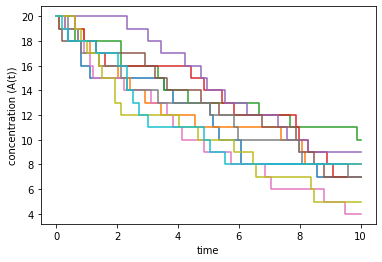

In [2]:
np.random.seed(3)

# Load a forward model
model = toy.stochastic.DegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 100)

for i in range(10):
    values = model.simulate(real_parameters, times)

    # Create an object with links to the model and time series
    problem = pints.SingleOutputProblem(model, times, values)

    # Create a uniform prior parameter
    log_prior = pints.GaussianLogPrior(0.15, 0.05)

    # Set the error measure to be used to compare simulated to observed data
    error_measure = pints.RootMeanSquaredError(problem)

    plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

## Fit using Rejection ABC

The Rejection ABC algorithm can be applied to sample parameter values. An error measure will be used to compare the difference between the stochastic simulation obtained with the true set of parameters and the stochastic simulation obtained with a candidate value. Our error measure of choice is the root mean squared error. Root mean squared error has been chosen in order to amplify smaller differences between two stochastic simulations in order to increase the quality of our samples.

In [3]:
np.random.seed(1)

abc = pints.ABCController(error_measure, log_prior, method=pints.HamiltonianABC)

def simulator_function(theta):
    if len(theta.shape) == 2:
        theta = theta[0]
    return model.simulate(theta, times)

# set target number of samples
abc.set_n_samples(50)
abc.sampler().set_y(values)
abc.sampler().set_theta0([0.15])
abc.sampler().set_sim_f(simulator_function)
abc.sampler().set_threshold(0.0000000001)
abc.sampler().set_step_size(0.000039)
abc.sampler().set_m(3)
abc.sampler().set_S(10)
abc.sampler().set_R(2)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Hamiltonian ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     1      2                0:02.4
2     2      1.5              0:04.7
3     3      1.333333333333   0:07.1


KeyboardInterrupt: 

In [27]:
print(samples)

[[0.15]
 [0.16412608109967475]
 [0.1828314523842258]
 [0.19227589033955544]
 [0.18170501676578482]
 [0.17935037832461012]
 [0.16852673541664157]
 [0.16398966336605]
 [0.1590265491095015]
 [0.16348037729800102]
 [0.16141858229667222]
 [0.16068208705599432]
 [0.1591857007039559]
 [0.15223953907969326]
 [0.15654658136785782]
 [0.1593025470719773]
 [0.16213625033721837]
 [0.15257361347746234]
 [0.15744123370051435]
 [0.1571855694217112]
 [0.16098559204963353]
 [0.16326250470457232]
 [0.1895227519337478]
 [0.18921859940299743]
 [0.19949494971536008]
 [0.19367870743247162]
 [0.19486733642835072]
 [0.19954022552185935]
 [0.19577978918864003]
 [0.18815409894445012]
 [0.18492866472482794]
 [0.1878523789721779]
 [0.19233414340064653]
 [0.19239401542386195]
 [0.18684323246443052]
 [0.18656082730024207]
 [0.18808674156337193]
 [0.19004649933274154]
 [0.21243528701808026]
 [0.213801908307604]
 [0.21308547086227572]
 [0.22070218078347667]
 [0.21740795193906115]
 [0.2186966459245335]
 [0.212007562318

In order to find the efficiency of the rejection ABC, we plot the approximate posterior compared to the actual parameter value. In the graph, we can see that there is a high concentration of samples around the value with which the data was generated. This suggests that the rejection ABC algorithm performs well and that the root mean squared error was a good choice as an error measure, since high quality samples were produced.

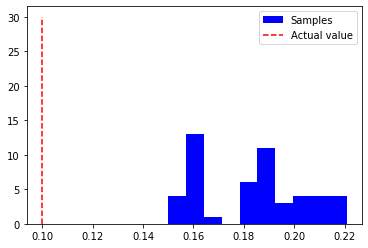

In [28]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=30, label="Actual value", color="red")
plt.legend()
plt.show()

# Note on Rejection ABC

The Rejection ABC algorithm is a highly simplistic method for Bayesian inference. As a consequence, it is inefficient when used with high variance priors.

Please make sure that you are monitoring the acceptance rate to see if this algorithm is working for your problem.